# AtliQ Products Analysis

## Contents

1. [Introduction](#introduction)
2. [Data loading and preprocessing](#data-loading-and-preprocessing)
    - [Import libraries](#libraries)
    - [Load/Download database](#loaddownload-database)
    - [Helper functions](#helper-functions)
    - [Basic tables info](#basic-tables-info)
    - [Missing values](#missing-values)
    - [Duplicates](#duplicates)
    - [Other](#other)
3. [Analysis](#analysis)
    1. [Finding the bestsellers](#finding-the-bestsellers)
    2. [Popularity across time and markets](#popularity-across-time-and-markets)
    3. [Variant sales]
    4. [Division sales]
    5. [Product margin]
    6. [Price vs cost]
4. [Conclusion]

---

## Introduction

Our team has been commissioned by AtliQ Hardware to conduct a thorough analysis of their product portfolio and sales data.

As a prominent computer hardware producer in India, AtliQ is keen on enhancing their understanding of product performance. This analysis aims to identify top-selling products, uncover trends, and develop strategies to optimize sales and market share.

The primary objective of this research is to analyze AtliQ Hardware's product portfolio and sales data to better understand product performance and identify strategies for optimizing sales. We aim to answer these key questions:
- Which items are the bestsellers?
- How has popularity changed over time/across markets?
- Are there some variants that contribute a disproportionate amount to the product sales?
- Are some channels responsible for a large portion of a division’s sales?
- What are the products with the best/worst margin?
- Is gross price keeping up with manufacturing costs?

Through this analysis, our goal is to provide AtliQ Hardware with actionable insights and recommendations to help drive business growth.

[Back to Contents](#contents)

---

## Data loading and Preprocessing

### Libraries
These are the libraries that we are going to use for this project:

In [1]:
import pandas as pd
import sqlite3
import os
import requests
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

[Back to Contents](#contents)

---

### Load/Download database

We have access to an SQLite database with data on products, clients and sales. 

First let's check that it exists, and if doesn't, we'll download it.

In [2]:
# Local path to the Database
db_directory_path = 'Data'
db_file_path = os.path.join(db_directory_path, 'atliq_db.sqlite3')


In [3]:
# Check if directory exists. If it doesn't, create it
if not os.path.exists(db_directory_path):
    os.makedirs(db_directory_path)


In [4]:
# Check if file exists. If it doesn't, download it
if not os.path.exists(db_file_path):
    print('Database not found. Downloading the file...')

    db_url = 'https://practicum-content.s3.us-west-1.amazonaws.com/data-eng/databases/atliq_db.sqlite3'
    
    response = requests.get(db_url)
    with open(db_file_path, 'wb') as f:
        f.write(response.content)
    
    print('Database downloaded successfully!')
else:
    print('Database found.')


Database found.


We have our database. But we don't want to directly change the raw data, and we will be working directly with the database as much as possible. So we'll make a copy and modify that instead.

In [5]:
# Check if the copy exists
work_db_path = os.path.join(db_directory_path, 'atliq_db_processed.sqlite3')

work_db_found = False
if os.path.exists(work_db_path):
    work_db_found = True
    print('Previous copy found.')
else:
    shutil.copyfile(db_file_path, work_db_path)
    print('Database duplicated.')


Previous copy found.


We can now connect to our working copy and start processing it. If we found that the copy already exists, we can assume that it is already processed, and we can skip those steps.

In [6]:
# Connect to the DB
con = sqlite3.connect(work_db_path)

Let's check that we have access to the tables that we are supposed to.

In [7]:
# Check all tables
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(*cursor.fetchall(), sep='\n')

('dim_customer',)
('dim_product',)
('fact_pre_discount',)
('fact_manufacturing_cost',)
('fact_gross_price',)
('fact_sales_monthly',)


[Back to contents](#contents)

---

### Helper functions

Lets check for missing values. We can't load the whole tables into pandas, so we'll have to rely only on SQL queries.

Lets build a function to help us, similar to pandas info().

We want to display the following:
- Table name
- Row count
- Column info, including name, type, null count, and Primary Key status.

In [8]:
# Count rows in the table
def row_count(table: str):
    query = """
    SELECT COUNT(*)
    from fact_sales_monthly
    """

    cursor.execute(query)
    return cursor.fetchone()[0]

In [9]:
# Find Null values in a column
def count_nulls_in_column(column: str, table: str):
    query = f"""
    SELECT COUNT(*)
    FROM {table}
    WHERE {column} IS NULL
    """

    cursor.execute(query)
    return cursor.fetchone()[0]

In [10]:
# Get all the column names from a table
def get_column_names(table: str):
    query = f"""
    PRAGMA table_info({table}) 
    """

    cursor.execute(query)
    result = cursor.fetchall()
    name_pos_in_row = 1

    column_names = []
    for row in result:
        column_names.append(row[name_pos_in_row])

    return column_names

In [11]:
# Check missing values in all columns of the table
def check_nulls(table: str):
    column_names = get_column_names(table)
    null_counts = []
    for column in column_names:
        null_counts.append((column, count_nulls_in_column(column, table)))

    return null_counts

In [12]:
def table_schema(table: str):
    query = f"""
    PRAGMA table_info({table})
    """

    return pd.read_sql_query(query, con)[['name', 'type', 'pk']]


In [13]:
def get_table_info(table: str):
    print(f'Table: {table}')
    print(f'Rows: {row_count(table)}')
    null_count = check_nulls(table)
    schema = table_schema(table)
    schema['nulls'] = [t[1] for t in null_count]
    display(schema)

To find duplicates, we'll compare the row count of a regular `SELECT` vs a `SELECT DISTINCT`, using relevant columns for each table.

In [14]:
def count_duplicates(table: str, list_cols: list, verbose=True):

    columns = ', '.join(list_cols)

    query = f"""
    SELECT COUNT(*)
    FROM {table}
    """
    cursor.execute(query)
    sel = cursor.fetchone()[0]

    query = f"""
    SELECT DISTINCT COUNT(*)
    FROM (
        SELECT DISTINCT {columns}
        FROM {table}
    )
    """
    cursor.execute(query)
    dis = cursor.fetchone()[0]
    duplicate_count = sel - dis

    if verbose:
        print(f'Table: {table}')
        print(f'Duplicates found: {duplicate_count}')
    return(duplicate_count)


[Back to Contents](#contents)

---

### Basic tables info

With our function ready, lets check the info on our tables.

In [15]:
display(get_table_info('dim_customer'))
cursor.execute("SELECT * FROM dim_customer LIMIT 5")
print(*cursor.fetchall(), sep='\n')

Table: dim_customer
Rows: 67250


,name,type,pk,nulls
0,customer_code,INTEGER,0,0
1,customer,TEXT,0,0
2,platform,TEXT,0,0
3,channel,TEXT,0,0
4,market,TEXT,0,0
5,sub_zone,TEXT,0,0
6,region,TEXT,0,0


None

(70002017, 'Atliq Exclusive', 'Brick & Mortar', 'Direct', 'India', 'India', 'APAC')
(70002018, 'Atliq e Store', 'E-Commerce', 'Direct', 'India', 'India', 'APAC')
(70003181, 'Atliq Exclusive', 'Brick & Mortar', 'Direct', 'Indonesia', 'ROA', 'APAC')
(70003182, 'Atliq e Store', 'E-Commerce', 'Direct', 'Indonesia', 'ROA', 'APAC')
(70004069, 'Atliq Exclusive', 'Brick & Mortar', 'Direct', 'Japan', 'ROA', 'APAC')


In [16]:
get_table_info('dim_product')
cursor.execute("SELECT * FROM dim_product LIMIT 5")
print(*cursor.fetchall(), sep='\n')

Table: dim_product
Rows: 67250


,name,type,pk,nulls
0,product_code,TEXT,0,0
1,division,TEXT,0,0
2,segment,TEXT,0,0
3,category,TEXT,0,0
4,product,TEXT,0,0
5,variant,TEXT,0,0
6,display_name,VARCHAR(15),0,379


('A0118150101', 'P & A', 'Peripherals', 'Internal HDD', 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache', 'Standard', 'AQ Dracula HDD')
('A0118150102', 'P & A', 'Peripherals', 'Internal HDD', 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache', 'Plus', 'AQ Dracula HDD')
('A0118150103', 'P & A', 'Peripherals', 'Internal HDD', 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache', 'Premium', 'AQ Dracula HDD')
('A0118150104', 'P & A', 'Peripherals', 'Internal HDD', 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache', 'Premium Plus', 'AQ Dracula HDD')
('A0219150201', 'P & A', 'Peripherals', 'Internal HDD', 'AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm', 'Standard', 'AQ Werewolf NAS')


In [17]:
get_table_info('fact_pre_discount')
cursor.execute("SELECT * FROM fact_pre_discount LIMIT 5")
print(*cursor.fetchall(), sep='\n')

Table: fact_pre_discount
Rows: 67250


,name,type,pk,nulls
0,customer_code,INTEGER,0,0
1,fiscal_year,INTEGER,0,0
2,pre_invoice_discount_pct,float,0,0


(70002017, 2018, 0.0824)
(70002017, 2019, 0.0777)
(70002017, 2020, 0.0735)
(70002017, 2021, 0.0703)
(70002017, 2022, 0.1057)


In [18]:
get_table_info('fact_manufacturing_cost')
cursor.execute("SELECT * FROM fact_manufacturing_cost LIMIT 5")
print(*cursor.fetchall(), sep='\n')

Table: fact_manufacturing_cost
Rows: 67250


,name,type,pk,nulls
0,product_code,TEXT,0,0
1,cost_year,INTEGER,0,0
2,manufacturing_cost,float,0,0


('A0118150101', 2018, 4.619)
('A0118150101', 2019, 4.2033)
('A0118150101', 2020, 5.0207)
('A0118150101', 2021, 5.5172)
('A0118150102', 2018, 5.6036)


In [19]:
get_table_info('fact_gross_price')
cursor.execute("SELECT * FROM fact_gross_price LIMIT 5")
print(*cursor.fetchall(), sep='\n')

Table: fact_gross_price
Rows: 67250


,name,type,pk,nulls
0,product_code,TEXT,0,0
1,fiscal_year,INTEGER,0,0
2,gross_price,float,0,0


('A0118150101', 2018, 15.3952)
('A0118150101', 2019, 14.4392)
('A0118150101', 2020, 16.2323)
('A0118150101', 2021, 19.0573)
('A0118150102', 2018, 19.5875)


In [20]:
get_table_info('fact_sales_monthly')
cursor.execute("SELECT * FROM fact_sales_monthly LIMIT 5")
print(*cursor.fetchall(), sep='\n')

Table: fact_sales_monthly
Rows: 67250


,name,type,pk,nulls
0,date,TEXT,0,0
1,product_code,TEXT,0,0
2,customer_code,INTEGER,0,0
3,sold_quantity,INTEGER,0,0
4,fiscal_year,INTEGER,0,0


('2017-09-01', 'A0118150101', 70002017, 51, 2018)
('2017-09-01', 'A0118150101', 70002018, 77, 2018)
('2017-09-01', 'A0118150101', 70003181, 17, 2018)
('2017-09-01', 'A0118150101', 70003182, 6, 2018)
('2017-09-01', 'A0118150101', 70006157, 5, 2018)


There is only one missing value in the whole database. 

Curiously, none of the tables have primary keys declared. 

The product names are too long. Let's create shorter display names.

In [21]:
# Checking which products are used
query = """
SELECT DISTINCT product
FROM dim_product JOIN fact_sales_monthly USING (product_code)
"""

cursor.execute(query)
print(*cursor.fetchall(), sep='\n')

('AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache',)
('AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm',)
('AQ Zion Saga',)
('AQ Mforce Gen X',)


We only have sales data on this 4 products. We can ignore the rest.

In [22]:
# Define display names
display_names = [
    'AQ Dracula HDD', 
    'AQ Werewolf NAS',
    'AQ Zion Saga',
    'AQ Mforce Gen X'
]

In [23]:
# Add the new column
query = """
ALTER TABLE dim_product
ADD display_name VARCHAR(15)
"""

try:
    cursor.execute(query);
except sqlite3.OperationalError:
    print('The column already exists.')


The column already exists.


In [24]:
# Update the table with the display names
for name in display_names:
    query = f"""
    UPDATE dim_product
    SET display_name = '{name}'
    WHERE product LIKE '{name}%'
    """

    cursor.execute(query)


In [25]:
# Check that the display names were correctly applied
query = """
SELECT DISTINCT display_name, product
FROM dim_product JOIN fact_sales_monthly USING (product_code)
"""

cursor.execute(query)
print(*cursor.fetchall(), sep='\n')

('AQ Dracula HDD', 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache')
('AQ Werewolf NAS', 'AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm')
('AQ Zion Saga', 'AQ Zion Saga')
('AQ Mforce Gen X', 'AQ Mforce Gen X')


In [26]:
con.commit()

Now we can use those shorter display names for our charts.

[Back to contents](#contents)

---

### Missing values

There is only one row with missing values in the whole Database. Let's print that row.

In [27]:
query='''
SELECT *
FROM fact_sales_monthly
WHERE fiscal_year IS NULL
'''

cursor.execute(query)
print(*cursor.fetchall(), sep='\n')

It's for product `A0` during `June 2019`. It could mean that this product didn't get any sales that month. Let's see some more info about it.

In [28]:
# Look for other sales of this product
query='''
SELECT *
FROM fact_sales_monthly
WHERE product_code = "A0"
'''

cursor.execute(query)
print(*cursor.fetchall(), sep='\n')

There are no other record of sales of this product.

In [29]:
# What product is this
query='''
SELECT *
FROM dim_product
WHERE product_code = "A0"
'''

cursor.execute(query)
print(*cursor.fetchall(), sep='\n')

There is no register of this product in `dim_product`. It doesn't exist. We can delete this row.

In [30]:
# What product is this
query='''
DELETE 
FROM fact_sales_monthly
WHERE product_code = "A0"
'''

cursor.execute(query)
print(*cursor.fetchall(), sep='\n')

con.commit()

[Back to Contents](#contents)

---

### Duplicates

The tables don't have Primary keys set up. That means it's possible that some of them have duplicated values in critical columns.

We'll be examining various column combinations in each table. Unless we encounter a non-zero value, we'll proceed to the next one.

In [31]:
# No duplicate customer codes
table = 'dim_customer'
columns = ['customer_code']
count_duplicates(table, columns);

Table: dim_customer
Duplicates found: 0


In [32]:
# Customer codes are unique to the ['customer', 'platform', 'channel', 'region'] combination
table = 'dim_customer'
columns = ['customer', 'platform', 'channel', 'region']
count_duplicates(table, columns);

Table: dim_customer
Duplicates found: 101


We got duplicates here. It's possible that the batabase notes are mistaken and `customer_code` is given by market, instead of by region.

In [33]:
# Check if adding 'market' to the previous query makes the results unique
table = 'dim_customer'
columns = ['customer', 'platform', 'channel', 'region', 'sub_zone', 'market']
count_duplicates(table, columns);

Table: dim_customer
Duplicates found: 0


It seems to be the case. We can move on.

In [34]:
# No duplicate product_code
table = 'dim_product'
columns = ['product_code']
count_duplicates(table, columns);

Table: dim_product
Duplicates found: 0


In [35]:
# No duplicate variants for the same product
table = 'dim_product'
columns = ['product', 'variant']
count_duplicates(table, columns);

Table: dim_product
Duplicates found: 0


In [36]:
# No duplicate category for the same product variant
table = 'dim_product'
columns = ['category', 'product', 'variant']
count_duplicates(table, columns);

Table: dim_product
Duplicates found: 0


In [37]:
# No duplicate segment for the same category product variant
table = 'dim_product'
columns = ['segment', 'category', 'product', 'variant']
count_duplicates(table, columns);

Table: dim_product
Duplicates found: 0


In [38]:
# No duplicate division for the same category product variant
table = 'dim_product'
columns = ['division', 'segment', 'category', 'product', 'variant']
count_duplicates(table, columns);

Table: dim_product
Duplicates found: 0


In [39]:
# The combination ['product', 'category', 'variant', 'segment', 'division'] should be unique
table = 'dim_product'
columns = ['product', 'category', 'variant', 'segment', 'division']
count_duplicates(table, columns);

Table: dim_product
Duplicates found: 0


In [40]:
# Each customer_code should have only one discount per fiscal_year
table = 'fact_pre_discount'
columns = ['customer_code', 'fiscal_year']
count_duplicates(table, columns);

Table: fact_pre_discount
Duplicates found: 0


In [41]:
# Each product_code should have only one cost per year
table = 'fact_manufacturing_cost'
columns = ['product_code', 'cost_year']
count_duplicates(table, columns);

Table: fact_manufacturing_cost
Duplicates found: 0


In [42]:
# Each product_code should have only one price per year
table = 'fact_gross_price'
columns = ['product_code', 'fiscal_year']
count_duplicates(table, columns);

Table: fact_gross_price
Duplicates found: 0


In [43]:
# The sales data should be aggrergated by customer, product and date.
table = 'fact_sales_monthly'
columns = ['date', 'product_code', 'customer_code']
count_duplicates(table, columns);

Table: fact_sales_monthly
Duplicates found: 0


We only found duplicates in `dim_customer`, and they are easily explainable. There is nothing to fix here.

[Back to Contents](#contents)

---

### Other

We should check the consistency of the data that we have, and that it obeys the rules stated in the Database documentation.

Let's see if the time period is the same in all tables.

In [44]:
# Period for fact_pre_discount data
query = """
SELECT MIN(fiscal_year), MAX(fiscal_year)
FROM fact_pre_discount
"""

cursor.execute(query)
cursor.fetchone()

(2018, 2022)

In [45]:
# Period for fact_manufacturing_cost data
query = """
SELECT MIN(cost_year), MAX(cost_year)
FROM fact_manufacturing_cost
"""

cursor.execute(query)
cursor.fetchone()

(2018, 2022)

In [46]:
# Period for fact_gross_price data
query = """
SELECT MIN(fiscal_year), MAX(fiscal_year)
FROM fact_gross_price
"""

cursor.execute(query)
cursor.fetchone()

(2018, 2022)

In [47]:
# Period for fact_sales_monthly data
query = """
SELECT MIN(fiscal_year), MAX(fiscal_year)
FROM fact_sales_monthly
"""

cursor.execute(query)
cursor.fetchone()

(2018, 2022)

All data is from fiscal years `2018` to `2022`

---

Some columns are supposed to have only certain values. Let's make sure that's the case, and there are no errors or typos.

In [48]:
# dim_customer.platform should have 2 values
query = """
SELECT DISTINCT platform
FROM dim_customer
"""
cursor.execute(query)
print(*cursor.fetchall(), sep="\n")

('Brick & Mortar',)
('E-Commerce',)


In [49]:
# dim_customer.channel should have 3 values
query = """
SELECT DISTINCT channel
FROM dim_customer
"""
cursor.execute(query)
print(*cursor.fetchall(), sep="\n")

('Direct',)
('Distributor',)
('Retailer',)


In [50]:
# dim_product.division should have 3 values
query = """
SELECT DISTINCT division
FROM dim_product
"""
cursor.execute(query)
print(*cursor.fetchall(), sep="\n")

('P & A',)
('PC',)
('N & S',)


In [51]:
# dim_product.segment should have 6 values
query = """
SELECT DISTINCT segment
FROM dim_product
"""
cursor.execute(query)
print(*cursor.fetchall(), sep="\n")

('Peripherals',)
('Accessories',)
('Notebook',)
('Desktop',)
('Storage',)
('Networking',)


---

There are some relationships that should be constant. For example, each market belongs to exactly one sub_zone. Let's check those relationships next.

The following cells should output `1` if there is no errors.

In [52]:
# Each dim_customer.customer_code should have 1 platform
query = """
SELECT customer_code, count(platform) as platform_count
FROM dim_customer
GROUP BY customer_code
ORDER BY platform_count DESC
"""
cursor.execute(query)
print (f'Max platform count: {cursor.fetchone()[1]}')

Max platform count: 1


In [53]:
# Each dim_customer.market should have 1 sub-zone
query = """
SELECT market, count(sub_zone) as sub_zone_count
FROM (
    SELECT DISTINCT market, sub_zone
    FROM dim_customer
)
GROUP BY market
ORDER BY sub_zone_count DESC
"""
cursor.execute(query)
print (f'Max sub zone count: {cursor.fetchone()[1]}')

Max sub zone count: 1


In [54]:
# Each dim_customer.market should have 1 region
query = """
SELECT market, count(region) as region_count
FROM (
    SELECT DISTINCT market, region
    FROM dim_customer
)
GROUP BY market
ORDER BY region_count DESC
"""
cursor.execute(query)
print (f'Max region count: {cursor.fetchone()[1]}')

Max region count: 1


---

Some columns should stay within reasonable values. Let's check that next.

In [55]:
# fact_pre_discount.pre_invoice_discount_pct should always be less than 1
query = """
SELECT max(pre_invoice_discount_pct)
FROM fact_pre_discount
"""
cursor.execute(query)
print(*cursor.fetchall(), sep="\n")

(0.3099,)


In [56]:
# fact_sales_monthly.date consistently assigns the same months to the right fiscal_year
query= """
SELECT fiscal_year, MIN(date), MAX(date)
FROM fact_sales_monthly
GROUP BY fiscal_year
"""
cursor.execute(query)
print(*cursor.fetchall(), sep="\n")

(2018, '2017-09-01', '2018-08-01')
(2019, '2018-09-01', '2019-08-01')
(2020, '2019-09-01', '2020-08-01')
(2021, '2020-09-01', '2021-08-01')
(2022, '2021-09-01', '2021-12-01')


There is only 3 months worth of data for fiscal year 2022, as opposed to the full 12 months for the rest of the fiscal years.

In [57]:
# fact_sales_monthly.sold_quantity should always be positive
query= """
SELECT MIN(sold_quantity)
FROM fact_sales_monthly
"""
cursor.execute(query)
print(*cursor.fetchall(), sep="\n")

(0,)


There are some items with `sold_quantity` of `0`. It's possible that means that the item didn't get any sales that month, but unlikely. 

Let's see those sales.

In [58]:
query= """
SELECT *
FROM fact_sales_monthly
WHERE sold_quantity = 0
"""
cursor.execute(query)
print(*cursor.fetchall(), sep="\n")

('2017-09-01', 'A0118150101', 70012042, 0, 2018)
('2017-09-01', 'A0118150101', 70012043, 0, 2018)
('2017-09-01', 'A0118150101', 90012033, 0, 2018)
('2017-09-01', 'A0118150101', 90012034, 0, 2018)
('2017-09-01', 'A0118150101', 90012035, 0, 2018)
('2017-09-01', 'A0118150101', 90012037, 0, 2018)
('2017-09-01', 'A0118150101', 90012038, 0, 2018)
('2017-09-01', 'A0118150101', 90012039, 0, 2018)
('2017-09-01', 'A0118150101', 90012041, 0, 2018)
('2017-09-01', 'A0118150102', 70012042, 0, 2018)
('2017-09-01', 'A0118150102', 70012043, 0, 2018)
('2017-09-01', 'A0118150102', 90012033, 0, 2018)
('2017-09-01', 'A0118150102', 90012034, 0, 2018)
('2017-09-01', 'A0118150102', 90012035, 0, 2018)
('2017-09-01', 'A0118150102', 90012037, 0, 2018)
('2017-09-01', 'A0118150102', 90012038, 0, 2018)
('2017-09-01', 'A0118150102', 90012039, 0, 2018)
('2017-09-01', 'A0118150102', 90012041, 0, 2018)
('2017-09-01', 'A0118150103', 70012042, 0, 2018)
('2017-09-01', 'A0118150103', 70012043, 0, 2018)
('2017-09-01', 'A011

All the sales with 0 quantity are from Sept 2017.

In [59]:
query = """
SELECT DISTINCT product
FROM (
    SELECT *
    FROM fact_sales_monthly
    WHERE sold_quantity = 0
) AS zero_sales 
INNER JOIN dim_product 
ON zero_sales.product_code = dim_product.product_code
"""
cursor.execute(query)
print(*cursor.fetchall(), sep='\n')

('AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache',)
('AQ Mforce Gen X',)


Only two products have this issue. We can delete these rows.

In [60]:
query = """
DELETE
FROM fact_sales_monthly
WHERE sold_quantity = 0
"""
cursor.execute(query);

The data is ready for analysis.

[Back to contents](#contents)

---

## Analysis

### Finding the bestsellers

There are different approaches that we can take here. We can find bestsellers by month to look for seasonality, by year to look at trend, or historical to see products that perform strongly year after year.

We can look at units sold, revenue, or profit. There's also the option of ranking by total values, or by their contribution (ratio) towards the grand total.

Right now we will only look at two of them, and leave the rest for the Dashboard.

The ones that we'll analyze here are:
- Most units sold in the last full year (2021)
- Most profit generated per year

We'll begin by finding the most units sold.

In [61]:
query = """
SELECT fiscal_year, dim_product.product_code, display_name, variant, SUM(sold_quantity) AS units_sold
FROM fact_sales_monthly 
    JOIN dim_product USING(product_code)
WHERE fiscal_year = 2021
GROUP BY fiscal_year, dim_product.product_code
ORDER BY units_sold DESC
"""

best_sell_df = pd.read_sql_query(query, con)
best_sell_df.head(5)


,fiscal_year,product_code,display_name,variant,units_sold
0,2021,A0219150201,AQ Werewolf NAS,Standard,100799
1,2021,A0118150101,AQ Dracula HDD,Standard,100039
2,2021,A0321150302,AQ Zion Saga,Plus,99955
3,2021,A0118150102,AQ Dracula HDD,Plus,98124
4,2021,A0118150104,AQ Dracula HDD,Premium Plus,97931


In [62]:

code_to_variant = dict(zip(best_sell_df['product_code'], best_sell_df['variant']))

fig = px.bar(data_frame=best_sell_df.sort_values(by='units_sold', ascending=False),
             x='product_code',
             y='units_sold',
             color='display_name',
             labels={
                 'product_code': 'Product variants',
                 'units_sold': 'Units sold'
                 },
             title='2021 Sales by Product Variant',
             )

fig.update_xaxes(labelalias =  code_to_variant)
fig.update_layout(legend_title_text='Product')
fig.show()

Most product variants had similar sales last year. The Dracula HDD was the best selling product overall (4 variants vs 3 of the Werewolf NAS and Zion Saga).

The Mforce Gen X is lagging behind.

How about yearly profit?

In [63]:
# Yearly profit
# First we'll create a view with the profit per sale.

query = """
CREATE VIEW IF NOT EXISTS profit_per_sale AS 
SELECT *, CAST((total_revenue - total_cost) AS int) AS total_profit
FROM (
    SELECT 
        fact_sales_monthly.*,
        gross_price,
        manufacturing_cost,
        pre_invoice_discount_pct,
        ((gross_price * (1 - pre_invoice_discount_pct)) * sold_quantity) AS total_revenue,
        (manufacturing_cost * sold_quantity) AS total_cost
        
    FROM fact_sales_monthly
        JOIN fact_manufacturing_cost 
            ON fact_manufacturing_cost.product_code = fact_sales_monthly.product_code
            AND fact_manufacturing_cost.cost_year = fact_sales_monthly.fiscal_year
        JOIN fact_gross_price 
            ON fact_gross_price.product_code = fact_sales_monthly.product_code
            AND fact_gross_price.fiscal_year = fact_sales_monthly.fiscal_year
        JOIN fact_pre_discount 
            ON fact_pre_discount.customer_code = fact_sales_monthly.customer_code
            AND fact_pre_discount.fiscal_year = fact_sales_monthly.fiscal_year
)

"""
cursor.execute(query);

In [64]:
# Calculate the profit per year

query = """
SELECT dim_product.product_code, display_name, variant, profit_per_sale.fiscal_year, SUM(total_profit) AS profit
FROM dim_product 
    JOIN profit_per_sale USING(product_code)
GROUP BY profit_per_sale.product_code, profit_per_sale.fiscal_year
ORDER BY profit DESC
"""

yearly_profit_df = pd.read_sql_query(query, con)
yearly_profit_df.head(5)

,product_code,display_name,variant,fiscal_year,profit
0,A0321150302,AQ Zion Saga,Plus,2022,2383543
1,A0321150303,AQ Zion Saga,Premium,2022,2227494
2,A0418150103,AQ Mforce Gen X,Standard 3,2022,2201061
3,A0219150202,AQ Werewolf NAS,Plus,2022,2032675
4,A0220150203,AQ Werewolf NAS,Premium,2022,2031093


In [65]:
# Calculate the profit per year

query = """
SELECT dim_product.product_code, display_name, variant, profit_per_sale.fiscal_year, SUM(total_profit) AS profit
FROM dim_product 
    JOIN profit_per_sale USING(product_code)
GROUP BY profit_per_sale.product_code, profit_per_sale.fiscal_year
ORDER BY profit DESC
"""

yearly_profit_df = pd.read_sql_query(query, con)
yearly_profit_df.head(5)

,product_code,display_name,variant,fiscal_year,profit
0,A0321150302,AQ Zion Saga,Plus,2022,2383543
1,A0321150303,AQ Zion Saga,Premium,2022,2227494
2,A0418150103,AQ Mforce Gen X,Standard 3,2022,2201061
3,A0219150202,AQ Werewolf NAS,Plus,2022,2032675
4,A0220150203,AQ Werewolf NAS,Premium,2022,2031093


In [66]:
# Create the stacked bar chart
fig = px.bar(yearly_profit_df.sort_values(by='fiscal_year', ascending=True),
              x='display_name',
              y='profit',
              color='variant',
              facet_col='fiscal_year',
              barmode='stack',
              facet_col_wrap=5,
              )

# Update axis titles
fig.update_xaxes(title_text='', showticklabels=True)
fig.update_yaxes(title_text='Profit')

annot = []
offset = 0.2
x_pos = 0.1
for year in yearly_profit_df.sort_values(by='fiscal_year', ascending=True)['fiscal_year'].unique():
    annot.append(
        dict(
            text = f'{year}',
            x = x_pos,
            y = 1,
            showarrow = False,
            xref = 'paper',
            yref='paper'
        )
    )
    x_pos += offset

# Update facet titles
fig.update_layout(
    title='Yearly Profit by Product',
    showlegend=True,
    legend_title='Variants',
    yaxis=dict(title=''), 
    annotations=annot
)

fig.show()

There has been a remarkable grow in the last years. Remember that this data has only the first 3 months of 2022!

The Mforce Gen X is also struggling to keep up when measuring profit. 

[Back to Contents](#contents)

### Popularity across time and markets

How has popularity changed over time and across markets?

In this section we'll be looking for seasonality, and patterns in markets.

First, lets see how each product sells during each month. Since we only have 3 months on 2022 we'll exclude it from this chart. We only want full years.

In [67]:
# Product sales per month
query = """
SELECT 
    display_name,
    date, 
    CAST(fiscal_year AS text) as fiscal_year, 
    SUBSTR('JanFebMarAprMayJunJulAugSepOctNovDec', 3 * CAST(strftime('%m', date) AS int) - 2, 3) AS month, 
    SUM(sold_quantity) as total_sold
FROM fact_sales_monthly
    JOIN dim_product USING(product_code)
WHERE fiscal_year != 2022
GROUP BY product, date
ORDER BY product, date ASC
"""

sales_by_month_df = pd.read_sql_query(query, con)


In [68]:
custom_colors=['#003f5c','#58508d', '#bc5090', '#ff6361', '#ffa600']
# Build a stacked bar chart with sales on each year.
fig = px.bar(data_frame=sales_by_month_df,
             x='month',
             y='total_sold',
             facet_col='display_name',
             color='fiscal_year',
             facet_col_wrap=1,
             facet_row_spacing=0.12,
             width=800,
             height=800,
             color_discrete_sequence=custom_colors
             )

# Update axis titles
fig.update_xaxes(title_text='', showticklabels=True)
fig.update_yaxes(title_text='')

# Remove "product=" prefix from facet labels
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

fig.update_layout(
    title='Total sales by month',
    legend_title_text='Fiscal year',
    showlegend=True
)


fig.show()

There is a jump in sales in the last months of the year. It happens with all the products.

It shows very clearly if we plot a historic chart.

In [69]:
# Build a stacked bar chart with sales on each year.

fig = px.bar(data_frame=sales_by_month_df,
             x='date',
             y='total_sold',
             facet_col='display_name',
             facet_col_wrap=1,
             color='fiscal_year',
             width =800,
             height=600,
             facet_row_spacing=0.12,

             color_discrete_sequence=custom_colors)

fig.update_yaxes(title='')
fig.update_xaxes(title='')

fig.for_each_annotation(lambda a: a.update(text = a.text.split('=')[1]))

fig.update_layout(
    title='Historic sales by month',
    legend_title_text='Fiscal year'
)
fig.show()

When it comes to popularity, three of our four products are growing year after year. These are:  Dracula HDD, WereWolf NAS and Zion Saga.

On the other hand, the Mforce Gen X has been dropping, and it appears that 2021 was it's weakest year.

---

Now lets analyze their performance in different markets.

First let's see which are our best performing markets.

In [70]:
query = """
SELECT market, MIN(fiscal_year) AS active_since, SUM(sold_quantity) AS units_sold
FROM fact_sales_monthly
    JOIN dim_customer USING(customer_code)
GROUP BY market
ORDER BY units_sold DESC
"""

market_sales_df = pd.read_sql_query(query,con)
market_sales_df.head(5)

,market,active_since,units_sold
0,India,2018,1087710
1,USA,2018,609825
2,South Korea,2018,341767
3,Canada,2018,197068
4,Philiphines,2018,191884


Now lets see what are these countries buying each year.


In [71]:
top_markets = ', '.join(market_sales_df.head(5)['market'].apply(lambda x: f"'{x}'"))
query = f"""
CREATE VIEW IF NOT EXISTS top_market_sales AS
SELECT market,
    product,
    display_name,
    SUM(CASE WHEN fiscal_year = 2018 THEN sold_quantity END) AS y2018,
    SUM(CASE WHEN fiscal_year = 2019 THEN sold_quantity END) AS y2019,
    SUM(CASE WHEN fiscal_year = 2020 THEN sold_quantity END) AS y2020,
    SUM(CASE WHEN fiscal_year = 2021 THEN sold_quantity END) AS y2021,
    SUM(CASE WHEN fiscal_year = 2022 THEN sold_quantity END) AS y2022
FROM dim_customer
    JOIN fact_sales_monthly USING(customer_code)
    JOIN dim_product USING(product_code)
WHERE market IN ({top_markets})
GROUP BY market, product
"""

cursor.execute(query);

In [72]:
query = """
SELECT 
    market || ': ' || display_name as market_prod,
    Y2018,
    Y2019,
    Y2020,
    Y2021,
    Y2022
from top_market_sales
"""
top_market_totals = pd.read_sql_query(query, con).set_index('market_prod')


<Axes: ylabel='market_prod'>

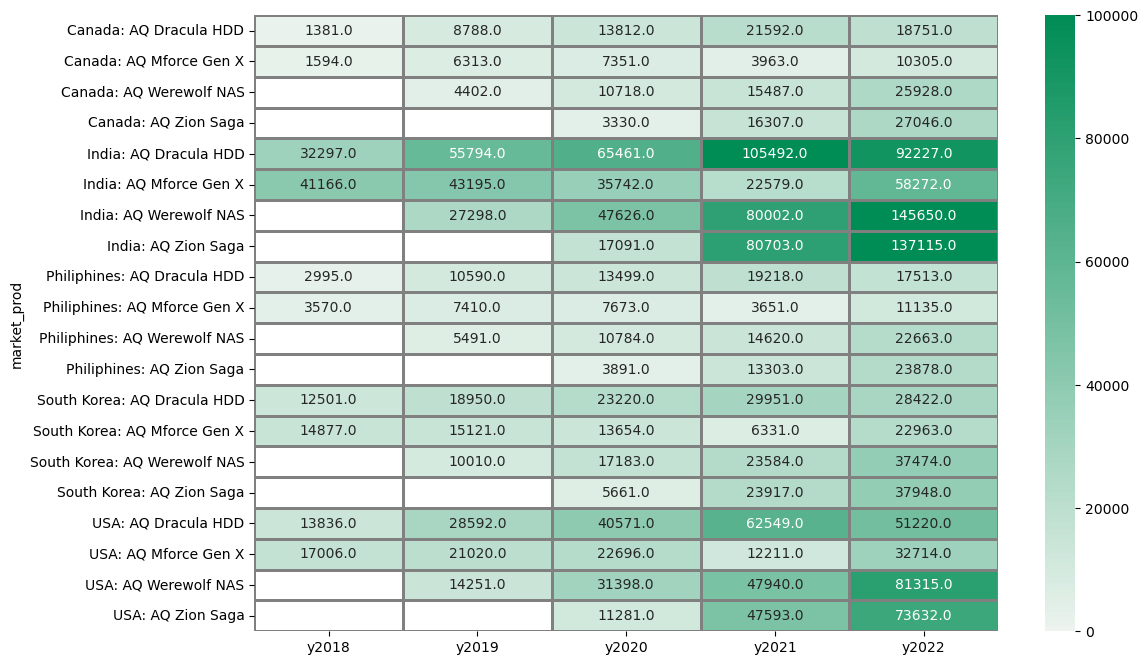

In [73]:
plt.figure(figsize=(12,8))

sns.heatmap(top_market_totals,
            vmin=0,
            vmax=100000,
            center=0,
            annot=True,
            fmt='0',
            linecolor='grey',
            linewidths=1,
            cmap=sns.diverging_palette(h_neg=20, h_pos=150, s=130, sep=1, as_cmap=True)

            )

We have the totals. Let's try to improve readability by changing it to change ratio compared to last year.

In [74]:
query="""
SELECT 
    market || ': ' || display_name as ind,
    (CAST(y2018 as float) / y2018) - 1 AS RY2018,
    (CAST(y2019 as float) / (CASE WHEN y2018 IS NULL THEN y2019 ELSE y2018 END)) - 1 AS RY2019,
    (CAST(y2020 as float) / (CASE WHEN y2019 IS NULL THEN y2020 ELSE y2019 END)) - 1 AS RY2020,
    (CAST(y2021 as float) / (CASE WHEN y2020 IS NULL THEN y2021 ELSE y2020 END)) - 1 AS RY2021,
    (CAST(y2022 as float) / (CASE WHEN y2021 IS NULL THEN y2022 ELSE y2021 END)) - 1 AS RY2022
FROM
    top_market_sales
"""

top_market_pop = pd.read_sql_query(query, con)

In [75]:
top_market_pop.set_index('ind', drop=True, inplace=True);

<Axes: ylabel='ind'>

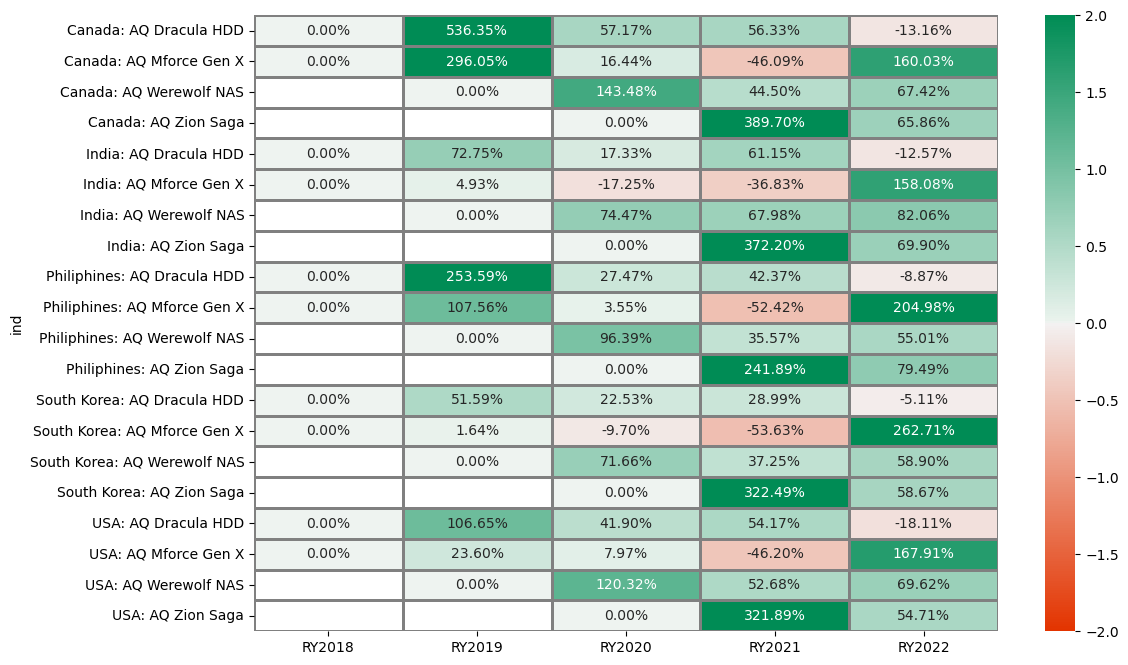

In [76]:
plt.figure(figsize=(12,8))

sns.heatmap(top_market_pop,
            vmin=-2,
            vmax=2,
            center=0,
            annot=True,
            fmt='.2%',
            linecolor='grey',
            linewidths=1,
            cmap=sns.diverging_palette(h_neg=20, h_pos=150, s=130, sep=1, as_cmap=True)

            )

The Werewolf NAS and Zion Saga 
